In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/PAC

/content/drive/MyDrive/Github/PAC


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from src import data
from src.segmentation import UNet
from src import metrics, measure
from src.config import Paths
from matplotlib import rcParams
rcParams['figure.figsize'] = (3, 3)
rcParams['image.cmap'] = 'gray'

In [4]:
models = []
for filepath in Paths.models.glob('unet*'):
    if filepath.is_dir():

        logs = UNet(filepath.stem).get_logs()
        best_epoch, min_val_area_mape = logs.loc[np.argmin(logs.val_area_mape)].loc[['epoch', 'val_area_mape']]

        configs = filepath.stem.split('-')
        models.append({
            'path': filepath,
            'stem': filepath.stem,
            'loss': configs[1],
            'filters': configs[2],
            'best_epoch': best_epoch + 1,
            'min_val_area_mape': min_val_area_mape
        })
models = pd.DataFrame(models)
models

,path,stem,loss,filters,best_epoch,min_val_area_mape
0,models/unet-binary_crossentropy-16_32_64,unet-binary_crossentropy-16_32_64,binary_crossentropy,16_32_64,340.0,0.450439
1,models/unet-dice-16_32_64,unet-dice-16_32_64,dice,16_32_64,238.0,0.460099
2,models/unet-dice_topk-16_32_64,unet-dice_topk-16_32_64,dice_topk,16_32_64,146.0,0.471773
3,models/unet-dice_topk_90-16_32_64,unet-dice_topk_90-16_32_64,dice_topk_90,16_32_64,102.0,0.853911
4,models/unet-dice-4_8_16_32,unet-dice-4_8_16_32,dice,4_8_16_32,794.0,0.504615
5,models/unet-dice_topk_30-32_64,unet-dice_topk_30-32_64,dice_topk_30,32_64,1.0,145.849396


In [5]:
def loss_by_name(name):
    loss = None
    try:
        loss = getattr(metrics, name)
    except:
        try: loss = getattr(tf.keras.losses, name)
        except: raise Exception(f'Função {name} não encontrada em tf.keras.losses ou em src.metrics')
    return loss

def get_metrics(model_name):
    logs = UNet(model_name).get_logs()
    my_metrics = []
    for col in logs.columns:
        if col not in ('epoch', 'loss') and 'val' not in col:
            try: my_metrics.append(getattr(metrics, col))
            except:
                try: my_metrics.append(getattr(tf.keras.metrics, col))
                except: raise Exception(f'Função {col} não encontrada em tf.keras.losses ou em src.metrics')
    return my_metrics

In [6]:
dataset = (x_train, y_train), (x_test, y_test) = data.load_dataset(augmentation=True, grayscale=True, norm=True)

In [7]:
best_model_info = models.loc[np.argmin(models.min_val_area_mape)]
best_model = UNet(best_model_info.stem, dataset).load(compile=False)
best_model.load_weights(int(best_model_info.best_epoch))
best_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss= loss_by_name(best_model_info.loss),
    metrics= get_metrics(best_model_info.stem)
)

In [8]:
best_model.evaluate()

2/2 [==============================] - 10s 5s/step - loss: 0.0262 - DSC: 0.9952 - IoU: 0.9904 - area_mape: 0.4504


[0.026240531355142593,
 0.9951502680778503,
 0.990355372428894,
 0.45043885707855225]

In [9]:
from scipy.stats import gaussian_kde

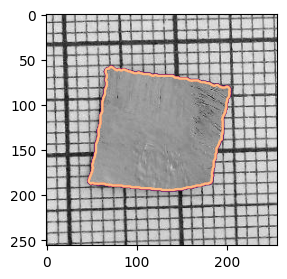

In [70]:
i = np.random.randint(len(x_test))
img = x_test[i, ..., 0].numpy()
lbl = best_model.predict(img[np.newaxis, ..., np.newaxis], verbose=0)[0, ..., 0] #y_test[i, ..., 0].numpy()
plt.imshow(img)
plt.contour(lbl, cmap='magma')

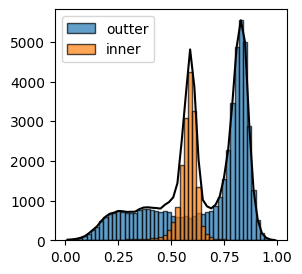

In [71]:
H, bins = np.histogram(img.flatten(), bins=50)
plt.hist(img[lbl < 0.5].flatten(), bins=bins, alpha=0.7, edgecolor='k', label='outter')
plt.hist(img[lbl > 0.5].flatten(), bins=bins, alpha=0.7, edgecolor='k', label='inner')
plt.plot((bins[1:] + bins[:-1])/2, H, 'k')
plt.legend()
plt.show()

In [ ]:
true, pred = [], []
for img, lbl, area in zip(*data.load_all('test/*', area=True, grayscale=True, norm=True, as_tensor=True)):
    for flipped_img in data.flipping_augmentation(img[np.newaxis]):
        y = best_model.predict(flipped_img[np.newaxis], verbose=0)
        pixel_area_pred = np.sum(y)
        scale = measure.find_scale(flipped_img[..., 0])[0]
        pred.append(pixel_area_pred*scale)
        true.append(area)
true, pred = np.array(true), np.array(pred)

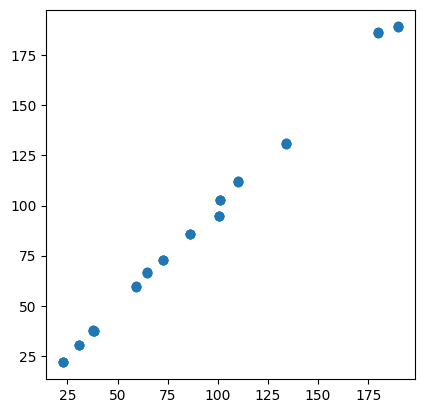

In [ ]:
fig, ax = plt.subplots()
plt.scatter(true, pred)
ax.set_aspect('equal')

In [ ]:
pd.Series(np.abs(true - pred)/true * 100).describe()

count    56.000000
mean      1.841547
std       1.587948
min       0.054028
25%       0.402041
50%       1.657528
75%       2.768106
max       5.504760
dtype: float64

In [72]:
from scipy.stats import wasserstein_distance

In [92]:
def func(x, y_pred):
    a = x[y_pred > 0.5]
    b = x[y_pred < 0.5]
    return wasserstein_distance(a, b)
'''def func(x, y_pred):
     a = np.ravel(x*y_pred)
     b = np.ravel(x*(1 - y_pred))
     return np.sum(((a - np.mean(a)) + (b - np.mean(b)))/np.prod(x.shape))'''

'def func(x, y_pred):\n     a = np.ravel(x*y_pred)\n     b = np.ravel(x*(1 - y_pred))\n     return np.sum(((a - np.mean(a)) + (b - np.mean(b)))/np.prod(x.shape))'

In [93]:
images, labels, areas = data.load_all('**/*', area=True, grayscale=True, norm=True, as_tensor=True)
#images = data.flipping_augmentation(images)
#labels = data.flipping_augmentation(labels)
#areas = np.repeat(areas, 4)
scales = np.stack([measure.find_scale(img)[0] for img in images[..., 0]])
summ = {
    'pred':[],
    'func':[],
    'DSC':[],
    'area_error':[]
}
logs = best_model.get_logs()
for epoch in logs.loc[np.isin(logs.val_area_mape, np.sort(logs.val_area_mape)[:1])].epoch:
    best_model.load_weights(int(epoch) + 1)
    pred = best_model.predict(images, verbose=0)
    pixel_area_pred = np.sum(pred, axis=(1, 2, 3))
    summ['pred'] += list(pixel_area_pred*scales)
    summ['func'] += [func(x, y) for x, y in zip(images[..., 0], pred[..., 0])]
    summ['DSC'] += list(metrics.DSC(tf.cast(labels, tf.float32), tf.cast(pred, tf.float32)))
    summ['area_error'] += list(np.abs(np.sum(labels, axis=(1, 2, 3)) - np.sum(pred, axis=(1, 2, 3))))
summ = pd.DataFrame(summ)

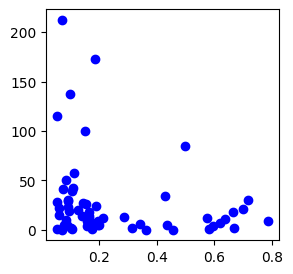

In [98]:
plt.scatter(summ.func, summ.area_error, c='b')

In [ ]:
from scipy.stats import pearsonr

In [ ]:
pearsonr(summ.func, error)

PearsonRResult(statistic=-0.07109312156860607, pvalue=0.2608515434108322)